# Numeric Methods Project

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. We got access to historical data: technical specifications, trim versions, and prices. Our objective is to build the model to determine car value. 

Project neet to take into consideration:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

**Table of Contents:** <a class="anchor" id='home'></a>
* [Data preparation](#data_preparation)
* [Data preparation conclusion](#data_conclusions)
* [Missing values and encoding](#missing_encoding)
* [Missing values and encoding conclusion](#missing_encoding_conclusions)
* [Testing models](#models)
* [Resuls and conclusion](#models_conclusion)

In [1]:
#conda install -c conda-forge lightgbm
#!pip install lightgbm
#! pip install graphviz==0.17.0
#!pip install --upgrade pip
#!pip install catboost
#!pip install xgboost

#pip install scikit-learn --upgrade
#! pip install -qU seaborn

In [2]:
import pandas as pd
import numpy as np
import sidetable
import missingno as msno
from multiprocessing import Pool

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
  
warnings.filterwarnings('ignore')

## Data preparation <a class="anchor" id='data_preparation'></a>

[Home](#home) 

In [3]:
try:
    car_data = pd.read_csv('C:/Users/vital/Downloads/car_data.csv')
except:
    car_data = pd.read_csv('/datasets/car_data.csv')

In [4]:
#See the data
car_data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [5]:
#Check data types
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

As dates themselfs could not be used in our cross sectional machine learning models, we will convert them to datetime and use days, weeks etc. as our features.

In [6]:
#Check for features with high-cardinality
car_data.nunique()

DateCrawled          15470
Price                 3731
VehicleType              8
RegistrationYear       151
Gearbox                  2
Power                  712
Model                  250
Mileage                 13
RegistrationMonth       13
FuelType                 7
Brand                   40
NotRepaired              2
DateCreated            109
NumberOfPictures         1
PostalCode            8143
LastSeen             18592
dtype: int64

In [7]:
#Check for missing values
car_data.stb.missing(style=True)

,missing,total,percent
NotRepaired,"71,154","354,369",20.08%
VehicleType,"37,490","354,369",10.58%
FuelType,"32,895","354,369",9.28%
Gearbox,"19,833","354,369",5.60%
Model,"19,705","354,369",5.56%
DateCrawled,0,"354,369",0.00%
Price,0,"354,369",0.00%
RegistrationYear,0,"354,369",0.00%
Power,0,"354,369",0.00%
Mileage,0,"354,369",0.00%


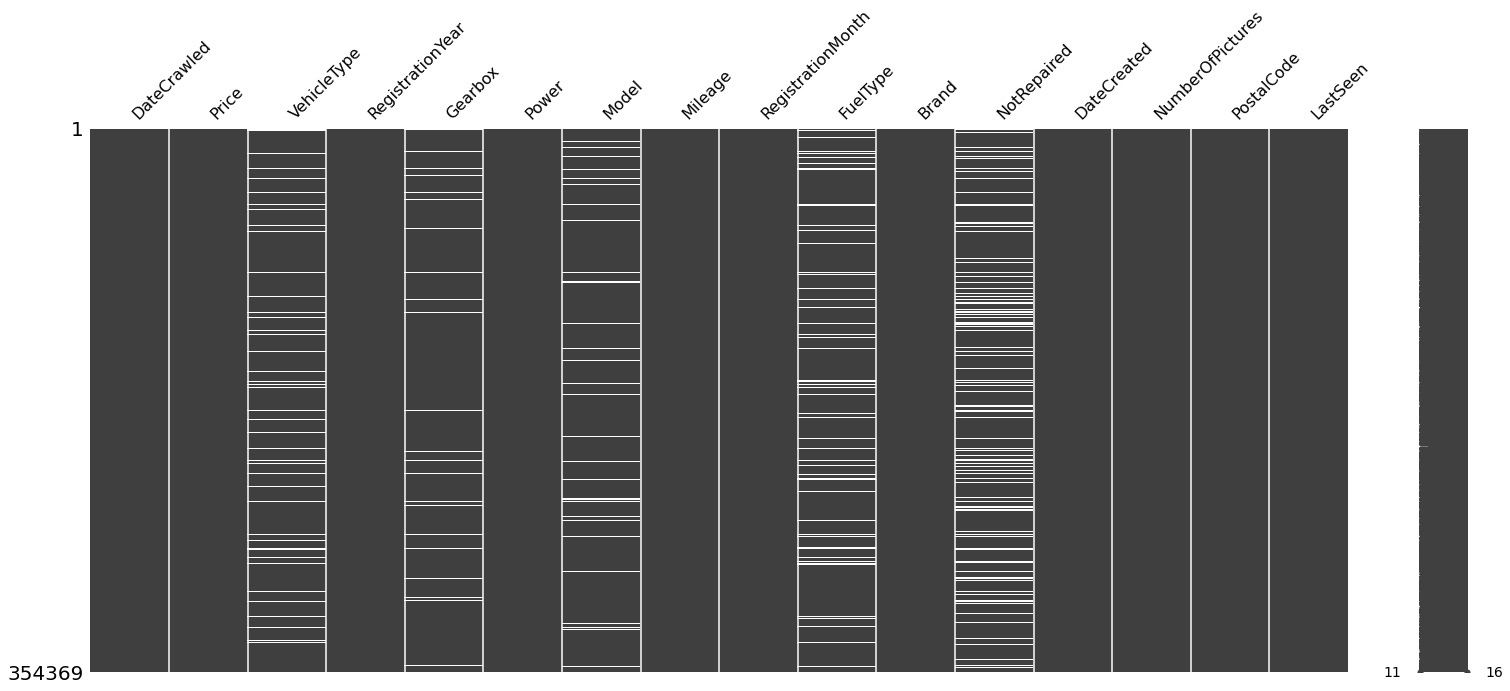

In [8]:
#Visualize missing values
msno.matrix(car_data);

We have missing values at 5 features and they are all object types.

In [9]:
#Check for duplicated rows
car_data.duplicated().sum()

262

We have 262 duplicated rows, we will check them again after filling missing values. 

In [10]:
#Check for descriptive statistics
car_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DateCrawled,354369,15470,05/03/2016 14:25,66,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,354369.0,NaN,NaN,NaN,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
VehicleType,316879,8,sedan,91457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RegistrationYear,354369.0,NaN,NaN,NaN,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Gearbox,334536,2,manual,268251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,354369.0,NaN,NaN,NaN,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Model,334664,250,golf,29232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mileage,354369.0,NaN,NaN,NaN,128211.172535,37905.34153,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,NaN,NaN,NaN,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
FuelType,321474,7,petrol,216352,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Conclusions - need to check:
 - [x] We have cars with price 0
 - [x] Registration year 1000
 - [x] Power 0
 - [x] Registration month 0
 - [x] Number of pictures, all 0

## Price

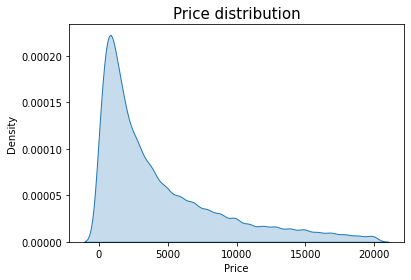

In [11]:
#See price distribution
sns.kdeplot(data=car_data, x='Price',fill=True, label='Price')
plt.title('Price distribution', size=15)
plt.show()

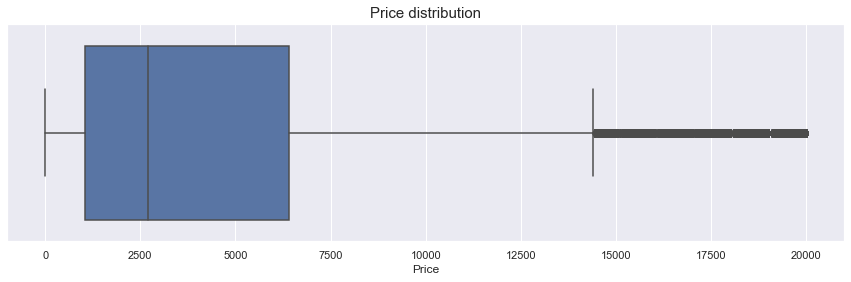

In [12]:
#Boxplot
sns.set(rc={'figure.figsize':(15,4)})
sns.boxplot(x=car_data["Price"])
plt.title('Price distribution', size=15)
plt.show()

Distribution skewed to the right

In [13]:
#Check for outliers
Q1 = car_data['Price'].quantile(0.25)
print('Q1:',Q1)
Q3 = car_data['Price'].quantile(0.75)
print('Q3:',Q3)
IQR = Q3 - Q1
print('IQR:',IQR)
print()
print('Low price outliers:',(Q1 - 1.5 * IQR))
print()
print('High price outliers:',(Q3 + 1.5 * IQR))

Q1: 1050.0
Q3: 6400.0
IQR: 5350.0

Low price outliers: -6975.0

High price outliers: 14425.0


In [14]:
#check percentiles
print(np.percentile(car_data['Price'], [5,95])) 

[  200. 14600.]


In [15]:
#check how many cars woth price lower than 200
print('Number of cars with price 0 Euro:',car_data[car_data['Price']<200]['Price'].value_counts().sum())
print()
print('Percentage of cars with price 0 Euro:',round(car_data[car_data['Price']<200]['Price'].value_counts().sum()/car_data.shape[0],2)*100,'%')

Number of cars with price 0 Euro: 17462

Percentage of cars with price 0 Euro: 5.0 %


In [16]:
#We will keep all data except cars with price less more 200 and less then 14,600 Euro
car_data_upd = car_data[(car_data.Price > 200) & (car_data.Price < 14600)]

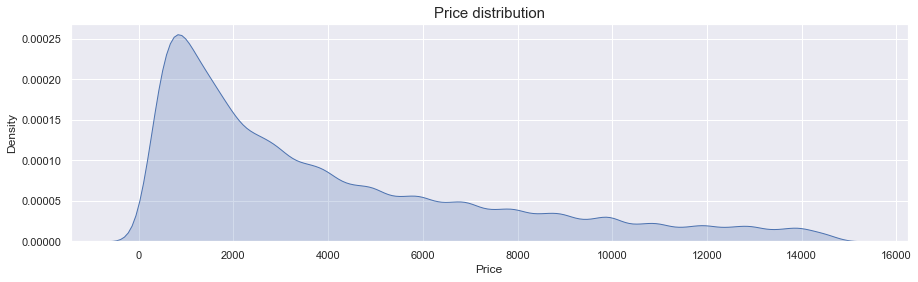

In [17]:
#See price distribution after removal of extremly low price cars
sns.kdeplot(data=car_data_upd, x='Price',fill=True, label='Price')
plt.title('Price distribution', size=15)
plt.show()

As the extreme low price cars are only 5%, the distribution didn't change

## Registration Year

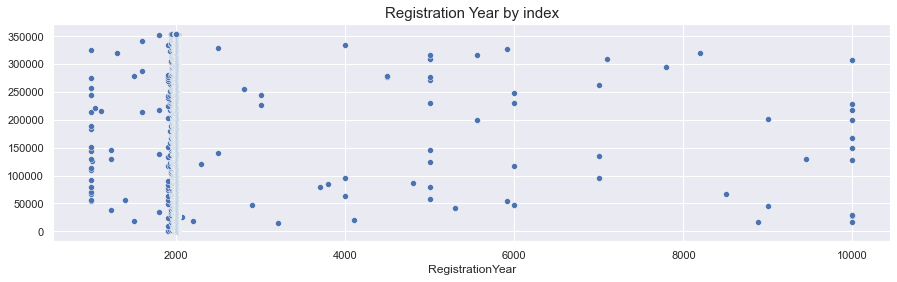

In [18]:
sns.scatterplot(data=car_data_upd, x="RegistrationYear", y=car_data_upd.index)
plt.title('Registration Year by index', size=15)
plt.show()

We have many strange outliers with very large year, while most of the data around year 2000.

In [19]:
#Check for outliers
Q1_regy = car_data_upd['RegistrationYear'].quantile(0.25)
print('Q1:',Q1_regy)
Q3_regy = car_data_upd['RegistrationYear'].quantile(0.75)
print('Q3:',Q3_regy)
IQR_regy = Q3_regy - Q1_regy
print('IQR:',IQR_regy)
print()
print('Year outliers below:',(Q1_regy - 1.5 * IQR_regy))
print()
print('Year outliers after:',(Q3_regy + 1.5 * IQR_regy))

Q1: 1999.0
Q3: 2007.0
IQR: 8.0

Year outliers below: 1987.0

Year outliers after: 2019.0


In [20]:
#check percentiles
print(np.percentile(car_data_upd['RegistrationYear'], [1, 99])) 

[1981. 2018.]


In [21]:
#We will keep all data except cars with year registration below 1980 and above 2021
car_data_upd = car_data_upd[(car_data_upd.RegistrationYear > 1980) & (car_data_upd.RegistrationYear < 2021)]

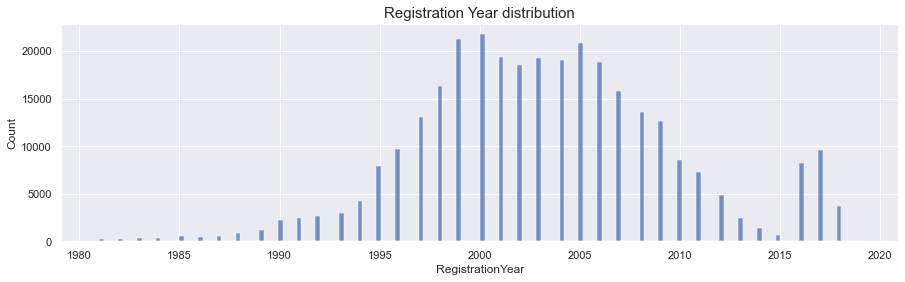

In [22]:
#See registration year distribution
sns.histplot(data=car_data_upd, x='RegistrationYear',fill=True, label='Price')
plt.title('Registration Year distribution', size=15)
plt.show()

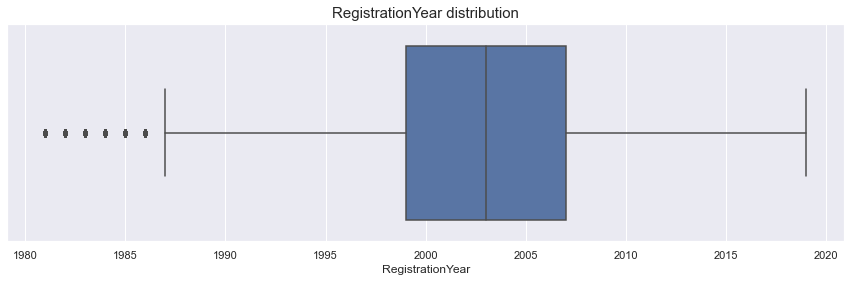

In [23]:
#Boxplot
sns.set(rc={'figure.figsize':(15,4)})
sns.boxplot(x=car_data_upd["RegistrationYear"])
plt.title('RegistrationYear distribution', size=15)
plt.show()

Registraion year distribution seems to be normal

## Power

Horsepower will typically be between 100 to 300

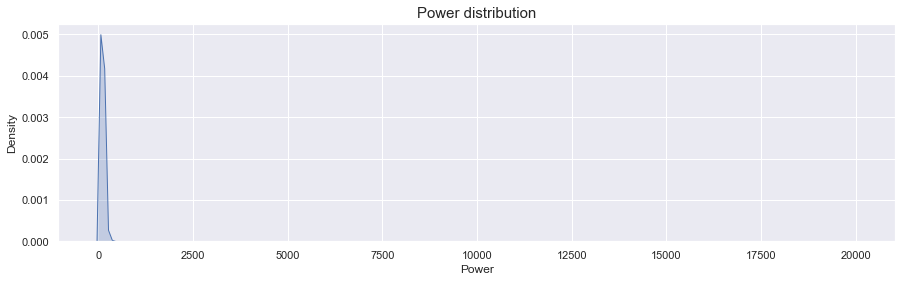

In [24]:
#See power distribution
sns.kdeplot(data=car_data_upd, x='Power',fill=True, label='Power')
plt.title('Power distribution', size=15)
plt.show()

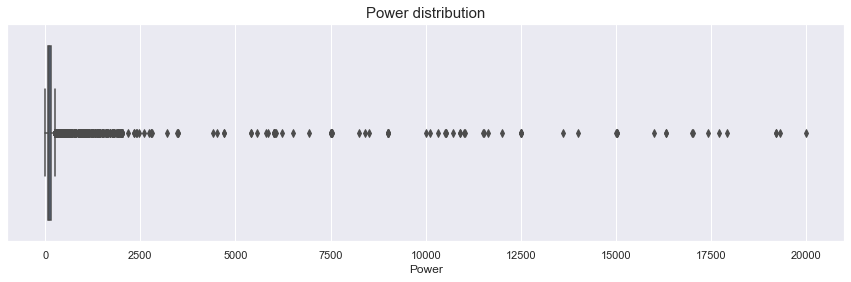

In [25]:
#Boxplot
sns.set(rc={'figure.figsize':(15,4)})
sns.boxplot(x=car_data_upd["Power"])
plt.title('Power distribution', size=15)
plt.show()

In [26]:
#check percentiles
print(np.percentile(car_data_upd['Power'], [10, 99])) 

[  0. 280.]


In [27]:
print('Number of cars with low HP:',car_data_upd[car_data_upd['Power']<40]['Power'].count())
print()
print('Percentage of cars with low HP:',round(car_data_upd[car_data_upd['Power']<40]['Power'].count()/car_data_upd.shape[0],3)*100,'%')

Number of cars with low HP: 32436

Percentage of cars with low HP: 10.299999999999999 %


In [28]:
#We will keep all data except cars with power below 40 and above 300
car_data_upd = car_data_upd[(car_data_upd.Power > 40) & (car_data_upd.Power < 301)]

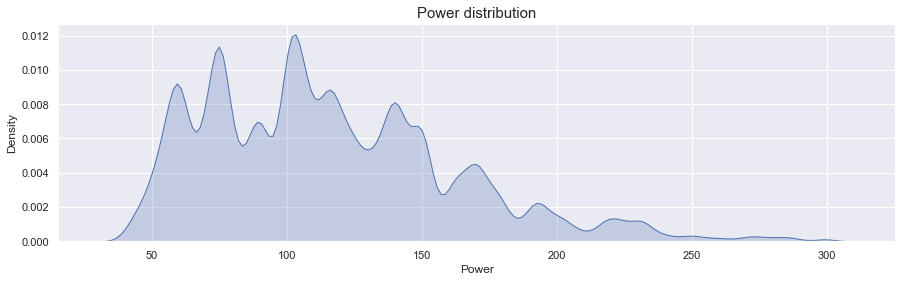

In [29]:
#See power distribution
sns.kdeplot(data=car_data_upd, x='Power',fill=True, label='Power')
plt.title('Power distribution', size=15)
plt.show()

Power now is distributed much more close to normal distribution.

## Registration month

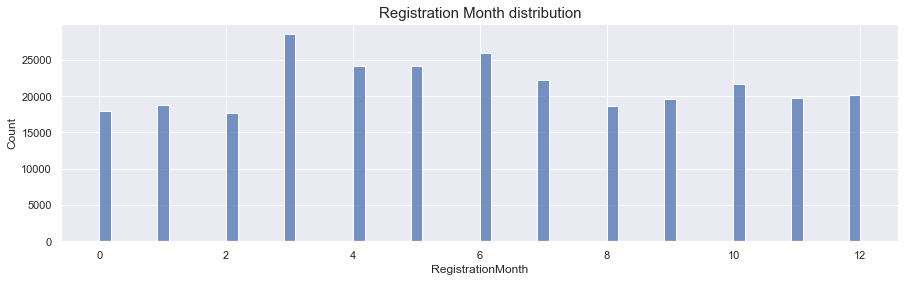

In [30]:
#See registration month distribution
sns.histplot(data=car_data_upd, x='RegistrationMonth',fill=True, label='Price')
plt.title('Registration Month distribution', size=15)
plt.show()

In [31]:
#check percentiles
print(np.percentile(car_data_upd['RegistrationMonth'], [1, 99])) 

[ 0. 12.]


In [32]:
#We will remove month 0
car_data_upd = car_data_upd[car_data_upd.RegistrationMonth != 0]

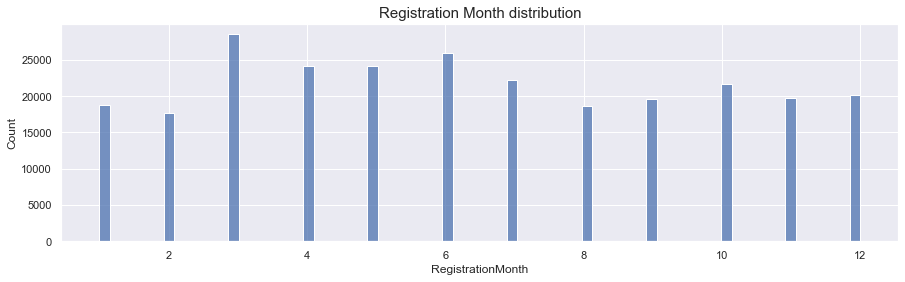

In [33]:
#See registration month distribution
sns.histplot(data=car_data_upd, x='RegistrationMonth',fill=True, label='Price')
plt.title('Registration Month distribution', size=15)
plt.show()

## Number of pictures

In [34]:
car_data_upd['NumberOfPictures'].value_counts()

0    261205
Name: NumberOfPictures, dtype: int64

No one of the cars have picture, this is irrelevant feature and should be removed.

In [35]:
car_data_upd = car_data_upd.drop(['NumberOfPictures'], axis=1)

### Descriptive statistics after normalizing data

In [36]:
#Check for descriptive statistics
car_data_upd.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DateCrawled,261205,14886,05/03/2016 14:25,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,261205.0,NaN,NaN,NaN,4237.479371,3554.996195,202.0,1400.0,3000.0,6290.0,14599.0
VehicleType,246553,8,sedan,72229,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RegistrationYear,261205.0,NaN,NaN,NaN,2003.35708,6.024021,1981.0,1999.0,2003.0,2007.0,2019.0
Gearbox,257386,2,manual,209794,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,261205.0,NaN,NaN,NaN,116.550246,46.531004,41.0,75.0,109.0,143.0,300.0
Model,252718,248,golf,22234,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mileage,261205.0,NaN,NaN,NaN,130428.781991,34558.92216,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,261205.0,NaN,NaN,NaN,6.391401,3.348032,1.0,4.0,6.0,9.0,12.0
FuelType,247819,7,petrol,166034,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
print('Percantge of data compared to initial data:', round(car_data_upd.shape[0]/car_data.shape[0],2)*100,'%')

Percantge of data compared to initial data: 74.0 %


In [38]:
car_data_upd.describe(include='all',datetime_is_numeric=True).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DateCrawled,261205,14886,05/03/2016 14:25,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,261205.0,NaN,NaN,NaN,4237.479371,3554.996195,202.0,1400.0,3000.0,6290.0,14599.0
VehicleType,246553,8,sedan,72229,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RegistrationYear,261205.0,NaN,NaN,NaN,2003.35708,6.024021,1981.0,1999.0,2003.0,2007.0,2019.0
Gearbox,257386,2,manual,209794,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,261205.0,NaN,NaN,NaN,116.550246,46.531004,41.0,75.0,109.0,143.0,300.0
Model,252718,248,golf,22234,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mileage,261205.0,NaN,NaN,NaN,130428.781991,34558.92216,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,261205.0,NaN,NaN,NaN,6.391401,3.348032,1.0,4.0,6.0,9.0,12.0
FuelType,247819,7,petrol,166034,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
#Check for duplicates
car_data_upd.duplicated().sum()

241

In [40]:
#Remove duplicates
car_data_upd = car_data_upd.drop_duplicates().reset_index(drop=True)

### Extracting from dates

In [41]:
#Convert dates into date types
car_data_upd['DateCrawled'] = pd.to_datetime(car_data_upd['DateCrawled'])
car_data_upd['DateCreated'] = pd.to_datetime(car_data_upd['DateCreated'])
car_data_upd['LastSeen'] = pd.to_datetime(car_data_upd['LastSeen'])

In [42]:
#Adding columns of day of week, month and hour
car_data_upd['DateCrawled_day_of_week'] = car_data_upd['DateCrawled'].dt.weekday
car_data_upd['DateCrawled_month'] =  car_data_upd['DateCrawled'].dt.month
car_data_upd['DateCrawled_hour'] =  car_data_upd['DateCrawled'].dt.hour

car_data_upd['DateCreated_day_of_week'] = car_data_upd['DateCreated'].dt.weekday
car_data_upd['DateCreated_month'] =  car_data_upd['DateCreated'].dt.month

car_data_upd['LastSeen_day_of_week'] = car_data_upd['LastSeen'].dt.weekday
car_data_upd['LastSeen_month'] =  car_data_upd['LastSeen'].dt.month
car_data_upd['LastSeen_hour'] =  car_data_upd['LastSeen'].dt.hour

In [43]:
#Remove dates columns
car_data_upd = car_data_upd.drop(['DateCrawled','DateCreated','LastSeen'],axis=1)

In [44]:
car_data_upd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260964 entries, 0 to 260963
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Price                    260964 non-null  int64 
 1   VehicleType              246314 non-null  object
 2   RegistrationYear         260964 non-null  int64 
 3   Gearbox                  257145 non-null  object
 4   Power                    260964 non-null  int64 
 5   Model                    252477 non-null  object
 6   Mileage                  260964 non-null  int64 
 7   RegistrationMonth        260964 non-null  int64 
 8   FuelType                 247579 non-null  object
 9   Brand                    260964 non-null  object
 10  NotRepaired              226791 non-null  object
 11  PostalCode               260964 non-null  int64 
 12  DateCrawled_day_of_week  260964 non-null  int64 
 13  DateCrawled_month        260964 non-null  int64 
 14  DateCrawled_hour    

In [45]:
car_data_upd.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode,DateCrawled_day_of_week,DateCrawled_month,DateCrawled_hour,DateCreated_day_of_week,DateCreated_month,LastSeen_day_of_week,LastSeen_month,LastSeen_hour
0,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,90480,0,3,12,0,3,2,5,12
1,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074,3,3,16,3,3,3,3,17
2,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437,3,3,17,3,3,5,6,10
3,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,33775,0,4,17,0,4,5,6,19
4,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,67112,0,1,20,0,1,2,5,18


## Conclusion - preparing the data <a class="anchor" id='data_conclusions'></a>

[Home](#home) 

At this part of the project we exemined the data and prepared it for work. We removed rows with not rational values to build stable and reliable model. <br>

 - We kept  cars with prices above 200 and less than 14,600 Euros
 - We kept cars with registration year between 1981 to 2021
 - We kep cars with Power between 41 to 300
 - We removed registration month 0
 - We removed Number of pictures as all values were 0
 
Finally we extracted day of week, month and hour from each one of the dates features as they can't be use in cross sectional machine learning and removed the dates.

# Fill missing values <a class="anchor" id='missing_encoding'></a>

[Home](#home) 

In order to avoid data leakage we will split the data to train and test sets and then fill the missing values.<br>
 - NotRepaired: fill with the most common value
 - VehicleType: using RegistrationYear, Gearbox, Power, Model and Brand
 - FuelType: using RegistrationYear, Gearbox, Power, Model, VehicleType and Brand
 - Model: using RegistrationYear, Gearbox, Power, FuelType, VehicleType and Brand
 - Gearbox: using RegistrationYear, Gearbox, Power, FuelType, VehicleType, Model and Brand

### Split data into train, validation and test

We will split the data into train and test sets and use train set as cross validation for hyperparameters tuning.

In [46]:
target = car_data_upd['Price']
features = car_data_upd.drop(['Price'], axis=1)

#Split data into train (70%) and test (30%)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=12345)

### Filling missing values - most common category based on features for each data set

In [47]:
missing_val_col = ['NotRepaired','VehicleType', 'FuelType', 'Model', 'Gearbox']

features_train['NotRepaired'].fillna(features_train['NotRepaired'].value_counts().index[0], inplace=True)
features_test['NotRepaired'].fillna(features_train['NotRepaired'].value_counts().index[0], inplace=True)

features_train['VehicleType'] = features_train['VehicleType'].fillna(features_train.groupby(['Brand', 'Model','Power','Gearbox','RegistrationYear'])['VehicleType'].value_counts().index[0][5])
features_train['FuelType'] = features_train['FuelType'].fillna(features_train.groupby(['Brand', 'Model','Power','Gearbox','RegistrationYear'])['FuelType'].value_counts().index[0][5])
features_train['Gearbox'] = features_train['Gearbox'].fillna(features_train.groupby(['Brand','Model','Power','VehicleType','RegistrationYear'])['Gearbox'].value_counts().index[0][5])
features_train['Model'] = features_train['Model'].fillna(features_train.groupby(['Brand','Power','Gearbox','VehicleType','RegistrationYear'])['Model'].value_counts().index[0][5])

features_test['VehicleType'] = features_test['VehicleType'].fillna(features_test.groupby(['Brand', 'Model','Power','Gearbox','RegistrationYear'])['VehicleType'].value_counts().index[0][5])
features_test['FuelType'] = features_test['FuelType'].fillna(features_test.groupby(['Brand', 'Model','Power','Gearbox','RegistrationYear'])['FuelType'].value_counts().index[0][5])
features_test['Gearbox'] = features_test['Gearbox'].fillna(features_test.groupby(['Brand','Model','Power','VehicleType','RegistrationYear'])['Gearbox'].value_counts().index[0][5])
features_test['Model'] = features_test['Model'].fillna(features_test.groupby(['Brand','Power','Gearbox','VehicleType','RegistrationYear'])['Model'].value_counts().index[0][5])

In [48]:
#Check for missing values train set
features_train[missing_val_col].stb.missing(style=True)

,missing,total,percent
NotRepaired,0,"182,674",0.00%
VehicleType,0,"182,674",0.00%
FuelType,0,"182,674",0.00%
Model,0,"182,674",0.00%
Gearbox,0,"182,674",0.00%


In [49]:
#Check for missing values test set
features_test[missing_val_col].stb.missing(style=True)

,missing,total,percent
NotRepaired,0,"78,290",0.00%
VehicleType,0,"78,290",0.00%
FuelType,0,"78,290",0.00%
Model,0,"78,290",0.00%
Gearbox,0,"78,290",0.00%


### Ordinal Encoding

In [50]:
#Encode categorical data into numerical represantaion in order to use the data with tree models
cat_features = ['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired'] #Categorical features to encode
rest_features = set(features_train)-set(features_train[cat_features]) #Other features

#Set unseen values to None
encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value=np.nan)
#We will use train data in order to have the same represantation for train and test sets
encoder.fit(features_train[cat_features])

features_train_ordinal = pd.merge(features_train[rest_features].reset_index(drop=True),pd.DataFrame(encoder.transform(features_train[cat_features]),columns=cat_features), left_index=True, right_index=True )
features_test_ordinal = pd.merge(features_test[rest_features].reset_index(drop=True),pd.DataFrame(encoder.transform(features_test[cat_features]),columns=cat_features), left_index=True, right_index=True )

In [51]:
print('Train shape:',features_train_ordinal.shape)
print('Test shape:',features_test_ordinal.shape)

Train shape: (182674, 19)
Test shape: (78290, 19)


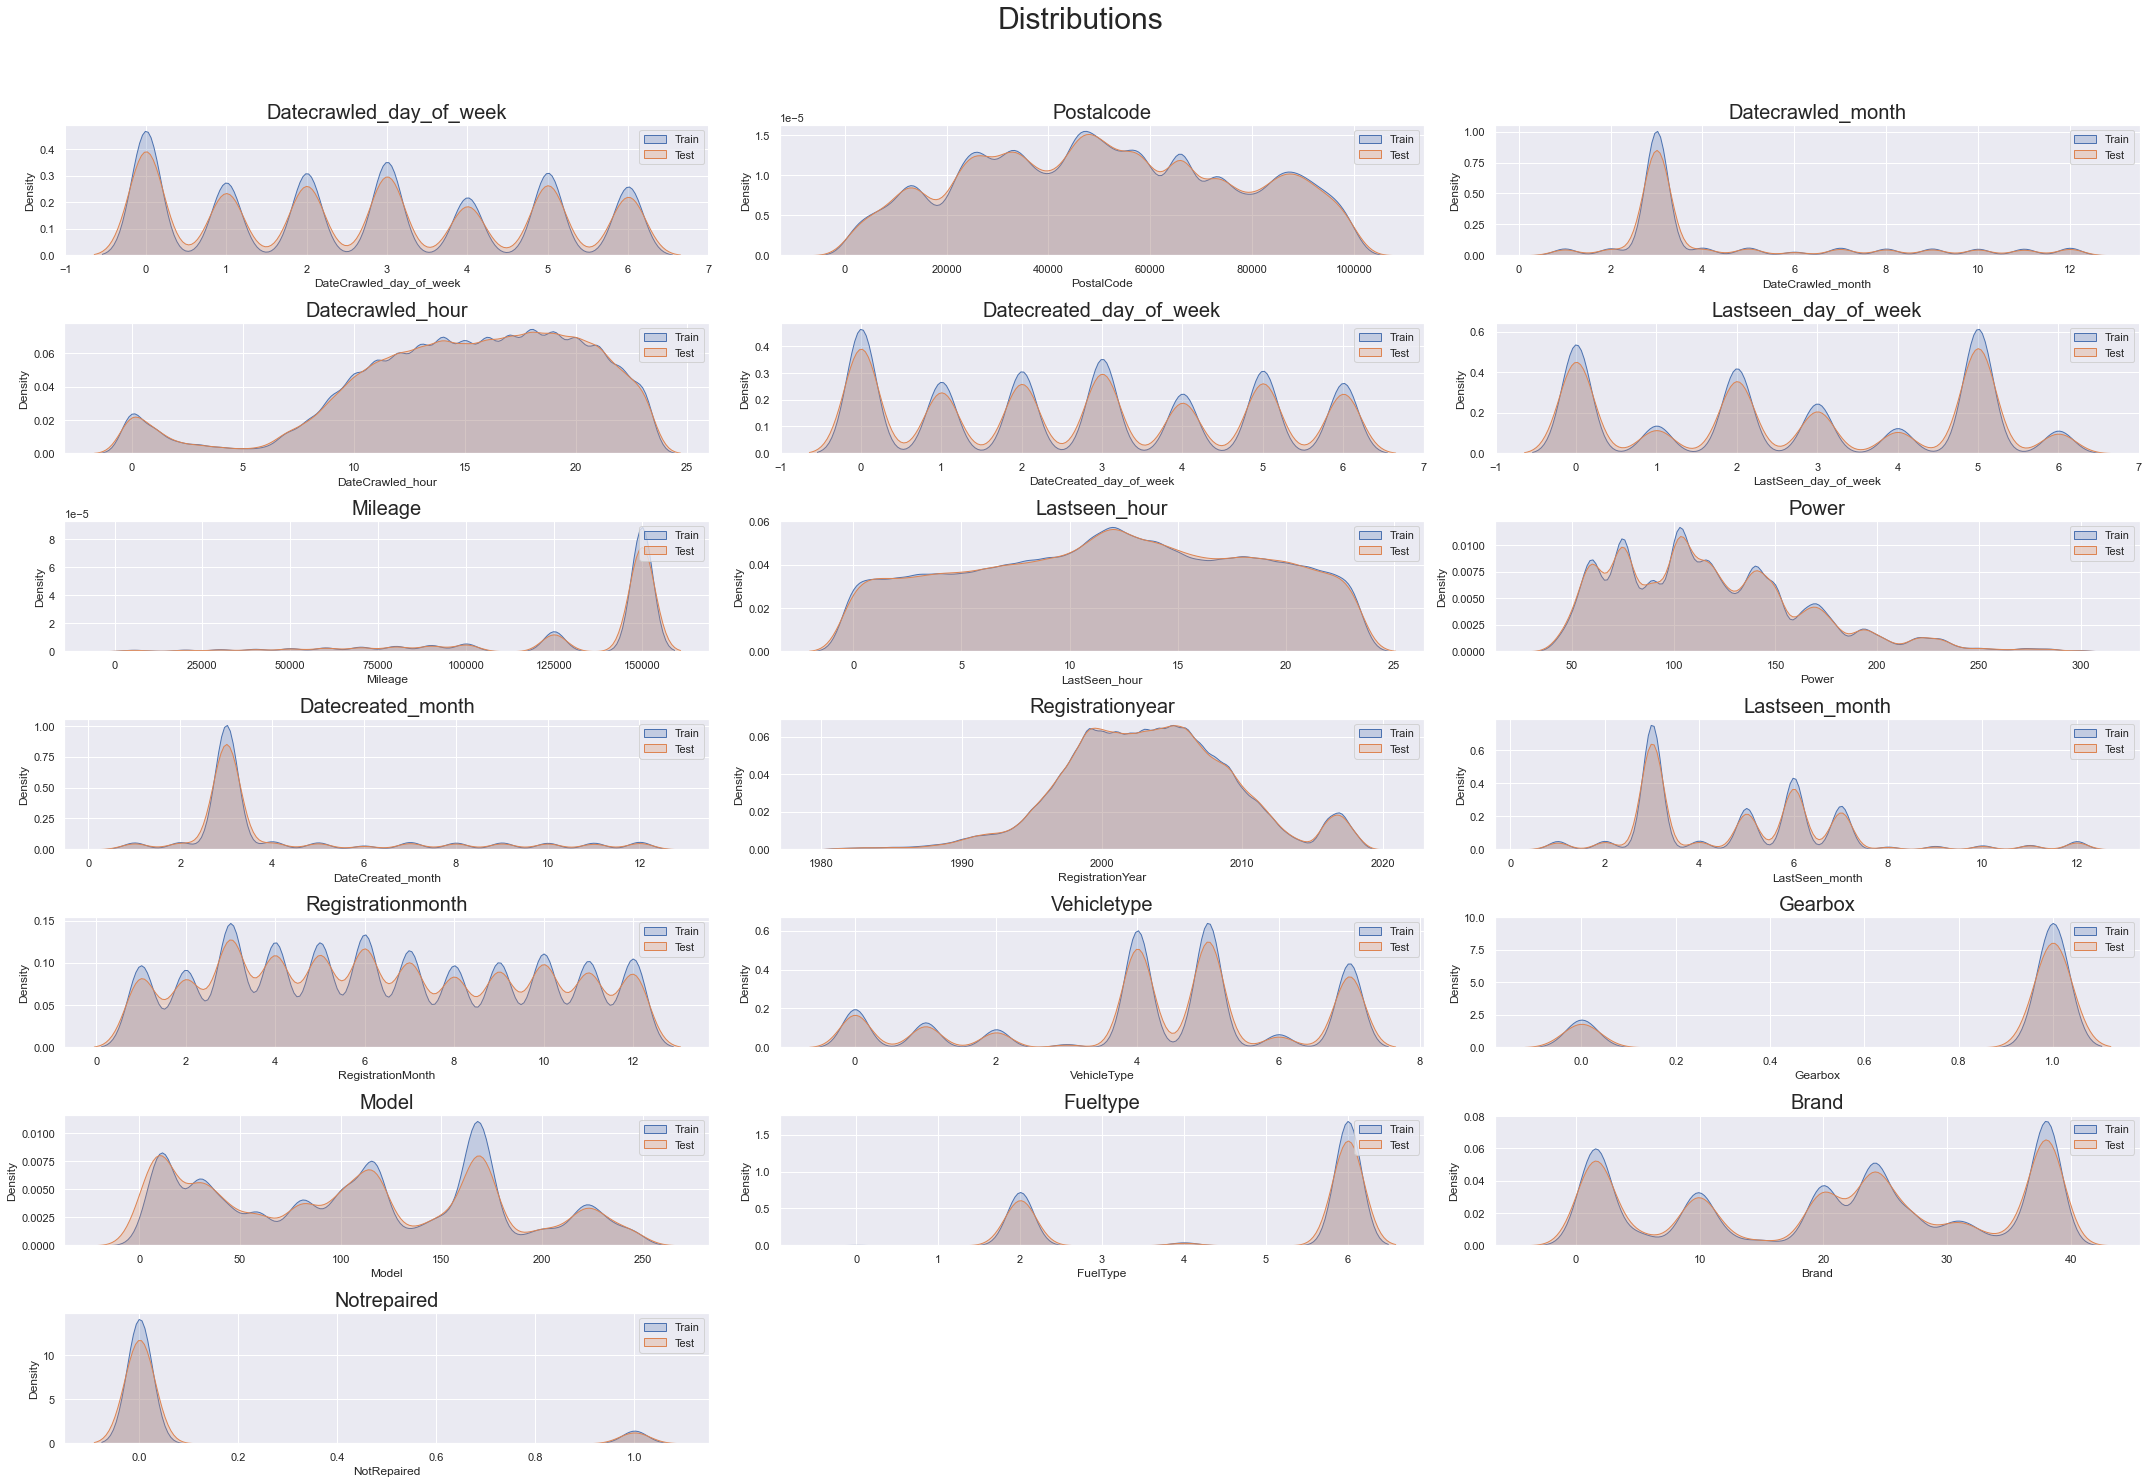

In [52]:
#Columns to plot
columns = features_train_ordinal.columns

#number of histograms:
hist_num = len(columns)

#Number of columns to present
col = 3

#numebr of rows to present
rows = int(hist_num/col)+1

#Create multiple plots:
fig, axs=plt.subplots(rows,col,figsize=(30, 20));

#Title for all histograms:
fig.suptitle('Distributions',  y=1.03, size=30)

for name, ax in zip(columns,np.ravel(axs)):
    sns.kdeplot(x=features_train_ordinal[name], ax=ax, label='Train', fill=True)
    sns.kdeplot(x=features_test_ordinal[name], ax=ax,label='Test', fill=True)
    ax.axes.set_title(name.capitalize(),fontsize=20)
    ax.legend()
    
plt.tight_layout()
fig.delaxes(axs[6][1])
fig.delaxes(axs[6][2])

### Scale the data to increase the effectivness of KNearest neighbors using vectors

In [53]:
scaler = MinMaxScaler()

#Fit with train data and transform to all others
features_train_ordinal_scaled = pd.DataFrame(scaler.fit_transform(features_train_ordinal), columns = features_train_ordinal.columns)

#test
features_test_ordinal_scaled = pd.DataFrame(scaler.transform(features_test_ordinal), columns = features_test_ordinal.columns)

In [54]:
print('Train shape:',features_train_ordinal_scaled.shape)
print('Test shape:',features_test_ordinal_scaled.shape)

Train shape: (182674, 19)
Test shape: (78290, 19)


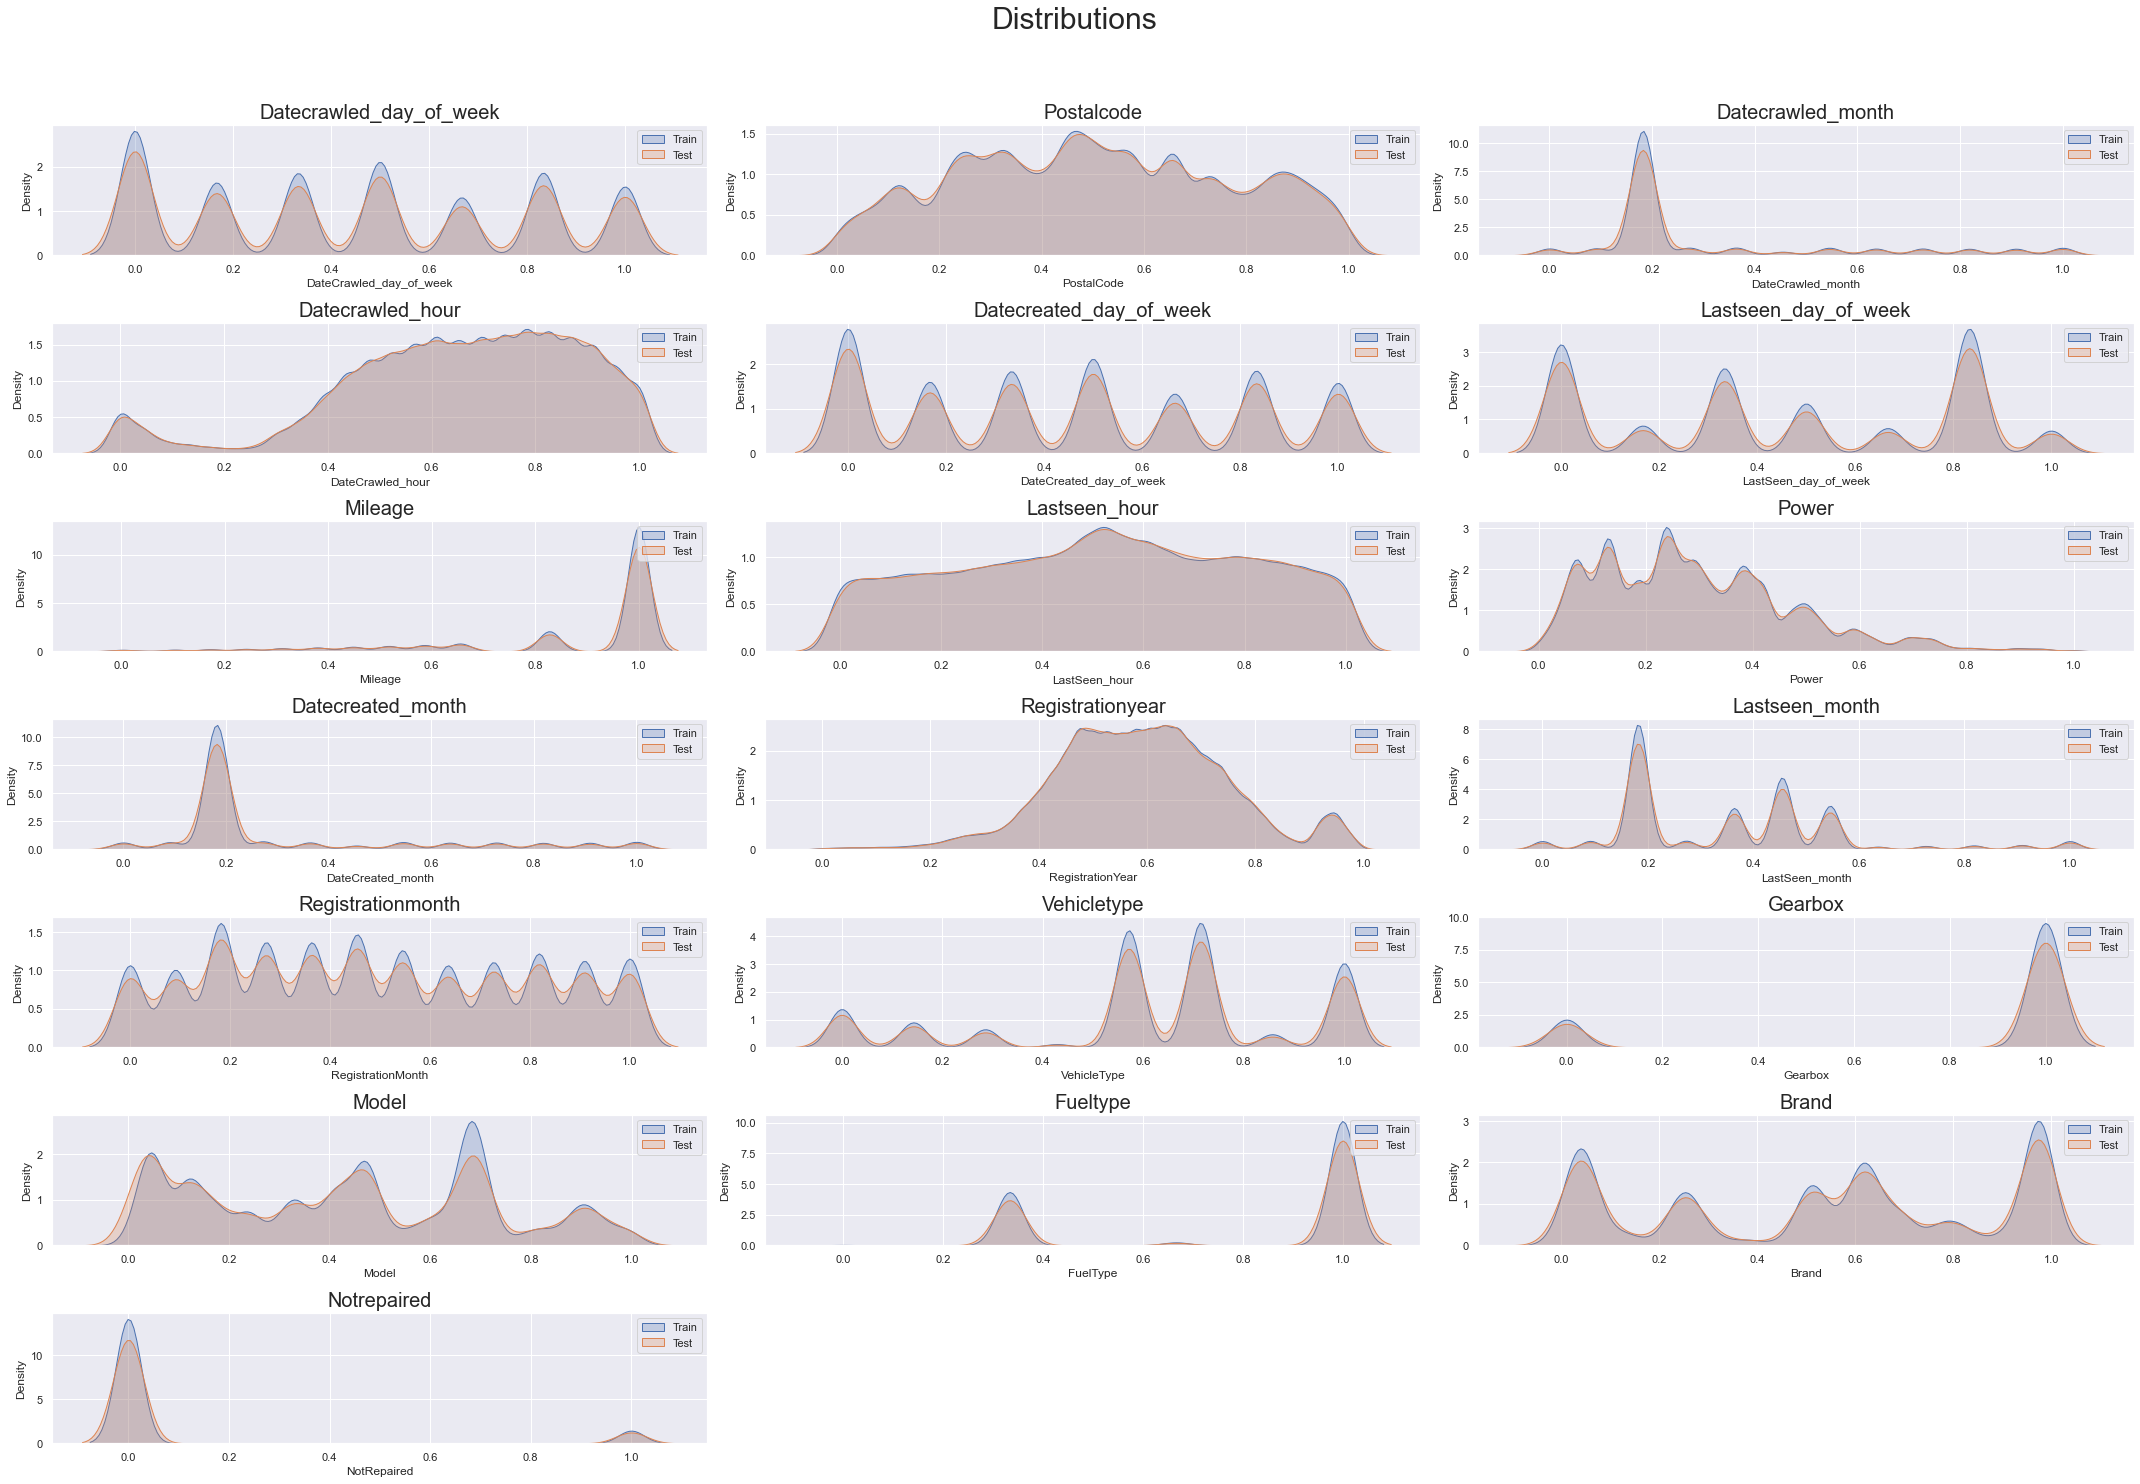

In [55]:
#Columns to plot
columns = features_train_ordinal.columns

#number of histograms:
hist_num = len(columns)

#Number of columns to present
col = 3

#numebr of rows to present
rows = int(hist_num/col)+1

#Create multiple plots:
fig, axs=plt.subplots(rows,col,figsize=(30, 20));

#Title for all histograms:
fig.suptitle('Distributions',  y=1.03, size=30)

for name, ax in zip(columns,np.ravel(axs)):
    sns.kdeplot(x=features_train_ordinal_scaled[name], ax=ax, label='Train', fill=True)
    sns.kdeplot(x=features_test_ordinal_scaled[name], ax=ax,label='Test', fill=True)
    ax.axes.set_title(name.capitalize(),fontsize=20)
    ax.legend()
    
plt.tight_layout()
fig.delaxes(axs[6][1])
fig.delaxes(axs[6][2])

As expected, features distribution remained the same after scaling.

**Note:** After scaling the data we can also try fill missing values with KNN imputer, we will try this if we won't be satisfyed with the results.

### OHE

When using One Hand Encoding, new columns will be created for each category (dummy variable). We need this for linear regression.

In [56]:
features_train[cat_features].nunique()

VehicleType      8
Gearbox          2
Model          247
FuelType         7
Brand           40
NotRepaired      2
dtype: int64

We see that for Model and Brand many features will be added to the data

In [57]:
features_train_ohe = pd.get_dummies(features_train[cat_features], drop_first = True)
features_test_ohe = pd.get_dummies(features_test[cat_features], drop_first = True)

In [58]:
features_train_ohe_all = pd.merge(features_train[rest_features],features_train_ohe, left_index=True, right_index=True )
features_test_ohe_all = pd.merge(features_test[rest_features],features_test_ohe, left_index=True, right_index=True )

In [59]:
print('Train shape:',features_train_ohe_all.shape)
print('Test shape:',features_test_ohe_all.shape)

Train shape: (182674, 313)
Test shape: (78290, 311)


### Conclusion - missing values and scalign <a class="anchor" id='missing_encoding_conclusions'></a>

[Home](#home) 

In this part we divided the data into train (70%) and test (30%) sets and then filled the missing values in order to avoid data leakage. We completend the missing values with mode vlaue based on similarity of other features. After filling missing values we encoded the data with OrderEncoder and converted categorical values into numercial values. Then we scaled the data using MinMaxScalar in order to be able to use these values with vectors. Finally we also create data using OHE in order to use LinearRegression.

<u>Categorical data</u>:<br>
features_train, features_test

<u>Numerical data</u>:<br>
features_train_ordinal, features_test_ordinal

<u>Scaled data</u>:<br>
features_train_ordinal_scaled, features_test_ordinal_scaled

<u>OHE data</u>:<br>
features_train_ohe_all, features_test_ohe_all


## Model analysis <a class="anchor" id='models'></a>

[Home](#home) 

We will use gridSearchCV with 5 k-folds and return RMSE metric.

In [60]:
#Check matrics
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [61]:
#Function to train model using GridSearchSV

#verbose=0, no information presented during the nprocess
#refit=True, fit the model in order to optimze score = smape
# best_score_ is sign-flip so we will use abs

def best_model (model, parm, train_X, train_y):
    model = GridSearchCV(model, parm, cv=5, verbose=0, refit=True, scoring='neg_root_mean_squared_error')
    model.fit(train_X, train_y)
    print('RMSE:',abs(model.best_score_))
    print()
    print('Best Parameters:',model.best_params_)
    print()
    return abs(model.best_score_)

In [62]:
#Check to mean price to understand the RMSE value
car_data_upd['Price'].mean()

4237.411459051823

In [63]:
#Create empty tuple for score
models_score = {}

#Create empty tuple for time
models_time = {}

### Linear Regression

In [64]:
%%time
lr = best_model(LinearRegression(), {},features_train_ohe_all, target_train)

models_score['Linear_regression'] = lr

RMSE: 2040.9291003279009

Best Parameters: {}

Wall time: 30 s


In [65]:
cv_results = cross_validate(LinearRegression(), features_train_ohe_all, target_train, cv=5,scoring=('neg_root_mean_squared_error'),)

In [66]:
print('RMSE:',abs(np.average(cv_results['test_score'])))
models_time['Linear_regression'] = np.average(cv_results['score_time'])+np.average(cv_results['fit_time'])
print('Running time:', models_time['Linear_regression'])

RMSE: 2040.9291003279009
Running time: 3.974332046508789


### Random Forest

In [240]:
%%time
# n_estimators - This is the number of trees
# max_depth - The maximum depth of the tree. Need to restriced to avoid overfitting

rf = best_model(RandomForestRegressor(random_state=12345), {
                        'n_estimators' : range(100, 150, 50),
                        'max_depth' : range(20, 30, 10)}, features_train_ordinal_scaled, target_train)

models_score['Random_forest'] = rf

RMSE: 1577.7192835611174

Best Parameters: {'max_depth': 30, 'n_estimators': 150}

Wall time: 46min 11s


In [87]:
cv_results_rf = cross_validate(RandomForestRegressor(random_state=12345, max_depth=30, n_estimators=150), features_train_ordinal_scaled, target_train, cv=5,scoring=('neg_root_mean_squared_error'),)

In [91]:
print('RMSE:',abs(np.average(cv_results_rf['test_score'])))
models_time['Random_forest'] = np.average(cv_results_rf['score_time'])+np.average(cv_results_rf['fit_time'])
print('Running time:', models_time['Random_forest'])

RMSE: 1338.1332803321227
Running time: 199.33446006774903


### KNN

In [147]:
%%time
# n_neighbors - Number of neighbors to use
# weights - Weight function used in prediction (uniform or distance)

knn = best_model(KNeighborsRegressor(), {
                        'n_neighbors' : [5,10,12],
                        'weights' : ['distance']}, features_train_ordinal_scaled, target_train)

models_score['KNearest_neighbors'] = knn

RMSE: 2353.5113546907664

Best Parameters: {'n_neighbors': 12, 'weights': 'distance'}

Wall time: 35min 24s


In [100]:
cv_results_knn = cross_validate(KNeighborsRegressor(n_neighbors=12, weights='distance'), features_train_ordinal_scaled, target_train, cv=5,scoring=('neg_root_mean_squared_error'),)
print('RMSE:',abs(np.average(cv_results_knn['test_score'])))
models_time['KNearest_neighbors'] = np.average(cv_results_knn['score_time'])+np.average(cv_results_knn['fit_time'])
print('Running time:', models_time['KNearest_neighbors'])

RMSE: 2353.5094546778114
Running time: 125.1622027873993


## Gradient boosting libraries

### LightGBM

**Categorical values**

In order to use categorical features in lighGBM we need to convert object type into category type

In [67]:
obj_feat = list(features_train.loc[:, features_train.dtypes == 'object'].columns)
obj_feat

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [68]:
for feature in obj_feat:
    features_train[feature] = pd.Series(features_train[feature], dtype="category")

In [69]:
%%time
# num_leaves - sets the maximum number of nodes per tree
# max_depth -  maximum distance between the root node of each tree and a leaf node

lightgbm1 = best_model(LGBMRegressor(random_state=12345), {
                        'num_leaves' : range(10, 90, 30),
                        'max_depth' : range(10, 30, 10)}, features_train, target_train)

models_score['Light_GBM_cat'] = lightgbm1

RMSE: 1283.196545999189

Best Parameters: {'max_depth': 20, 'num_leaves': 70}

Wall time: 59.6 s


In [70]:
cv_results_lgbm_cat = cross_validate(LGBMRegressor(random_state=12345, num_leaves=70, max_depth=20), features_train, target_train, cv=5,scoring=('neg_root_mean_squared_error'),)
print('RMSE:',abs(np.average(cv_results_lgbm_cat['test_score'])))
models_time['Light_GBM_cat'] = np.average(cv_results_lgbm_cat['score_time'])+np.average(cv_results_lgbm_cat['fit_time'])
print('Running time:', models_time['Light_GBM_cat'])

RMSE: 1283.196545999189
Running time: 2.2785223484039308


**Numerical values**

In [85]:
%%time
# num_leaves - sets the maximum number of nodes per tree
# max_depth -  maximum distance between the root node of each tree and a leaf node
# num_iterations - number of boosting rounds that will be performed

lightgbm2 = best_model(LGBMRegressor(random_state=12345), {
                        'num_leaves' : range(10, 90, 30),
                        'max_depth' : range(10, 30, 10)}, features_train_ordinal, target_train)

models_score['Light_GBM_ord'] = lightgbm2

RMSE: 1331.452921802922

Best Parameters: {'max_depth': 20, 'num_leaves': 70}

Wall time: 49.7 s


In [97]:
cv_results_lgbm_ord = cross_validate(LGBMRegressor(random_state=12345, num_leaves=70, max_depth=20), features_train, target_train, cv=5,scoring=('neg_root_mean_squared_error'),)
print('RMSE:',abs(np.average(cv_results_lgbm_ord['test_score'])))
models_time['Light_GBM_ord'] = np.average(cv_results_lgbm_ord['score_time'])+np.average(cv_results_lgbm_ord['fit_time'])
print('Running time:', models_time['Light_GBM_ord'])

RMSE: 1283.196545999189
Running time: 1.683543348312378


### CatBoost

In [86]:
%%time
# n_estimators (iterations) - The maximum number of trees that can be built
#learning_rate - reducing the gradient step

#In CatBoost we need to define what are the categorical variables

catboost = best_model(CatBoostRegressor(random_state=12345,cat_features = obj_feat), {
                        'n_estimators' : range(200, 300, 50),
                        'learning_rate':[0.4],
                        'verbose':[False],
                        'loss_function':['RMSE']}, features_train, target_train)

models_score['CatBoost'] = catboost

RMSE: 1300.3808389444166

Best Parameters: {'learning_rate': 0.4, 'loss_function': 'RMSE', 'n_estimators': 250, 'verbose': False}

Wall time: 5min 6s


In [98]:
cv_results_cat = cross_validate(CatBoostRegressor(cat_features = obj_feat, loss_function='RMSE', random_state=12345, learning_rate=0.4, n_estimators=250, verbose=False), features_train, target_train, cv=5,scoring=('neg_root_mean_squared_error'),)
print('RMSE:',abs(np.average(cv_results_cat['test_score'])))
models_time['CatBoost'] = np.average(cv_results_cat['score_time'])+np.average(cv_results_cat['fit_time'])
print('Running time:', models_time['CatBoost'])

RMSE: 1300.3808389444166
Running time: 26.15045895576477


### XGBoost

The oldest gradient boosting algorithm of the three, it uses only numerical values

In [98]:
%%time
#As the runtime is very long I use only the best parameters

# n_estimators - number of boosting rounds that will be performed
# max_depth -  maximum distance between the root node of each tree and a leaf node

xgboost = best_model(xgb.XGBRegressor(random_state=12345), {
                        'n_estimators' : [250],
                        'max_depth' : [20],
                        'objective' :['reg:squarederror']}, features_train_ordinal, target_train)

models_score['XGBoost'] = xgboost

RMSE: 1404.083171155863

Best Parameters: {'max_depth': 20, 'n_estimators': 250}

Wall time: 52min 6s


In [116]:
cv_results_xgboost = cross_validate(xgb.XGBRegressor(random_state=12345, objective='reg:squarederror', max_depth=20, n_estimators=250), features_train_ordinal, target_train, cv=5,scoring=('neg_root_mean_squared_error'),)
print('RMSE:',abs(np.average(cv_results_xgboost['test_score'])))
models_time['XGBoost'] = np.average(cv_results_xgboost['score_time'])+np.average(cv_results_xgboost['fit_time'])
print('Running time:', models_time['XGBoost'])

RMSE: 1403.5984696087883
Running time: 143.0989453792572


## Results <a class="anchor" id='models_conclusion'></a>

[Home](#home) 

In [120]:
#Best score
pd.DataFrame.from_dict(models_score, orient='index',columns=['score']).sort_values(by='score').head(1)

,score
Light_GBM_cat,1283.196546


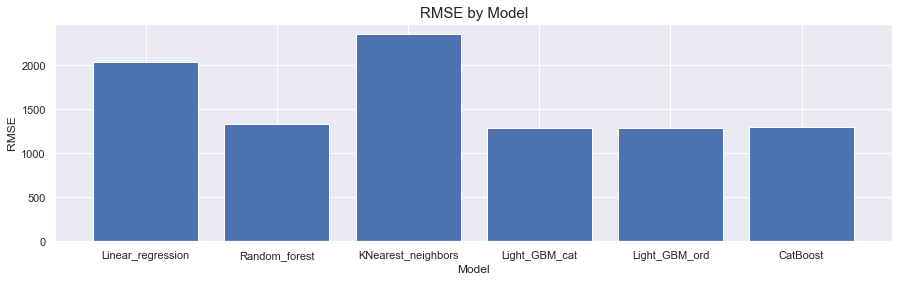

In [117]:
#compare models results
keys_score = models_score.keys()
values_score = models_score.values()

plt.bar(keys_score, values_score)
plt.title('RMSE by Model', size=15)
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.show()

In [118]:
#Percentage error
print('RMSE in terms of percentage:',round(models_score['CatBoost']/car_data_upd['Price'].mean(),2)*100,'%')

RMSE in terms of percentage: 31.0 %


The error is around 30% which is high but this is mainly due to the metric which is punishing large mistakes with more weight.

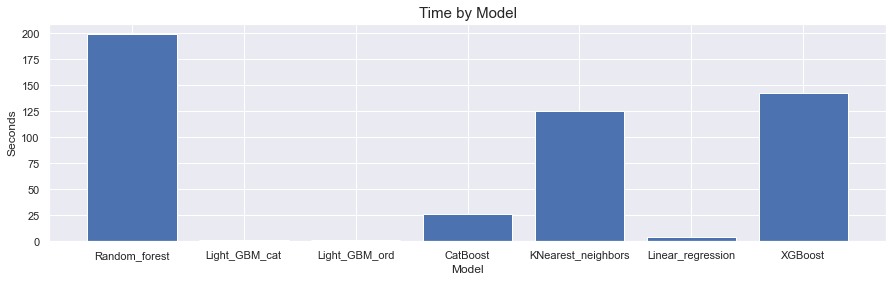

In [119]:
#compare models times
keys = models_time.keys()
values = models_time.values()

plt.bar(keys, values)
plt.title('Time by Model', size=15)
plt.xlabel('Model')
plt.ylabel('Seconds')
plt.show()

## Conclusion

The lowest RMSE was for LightGBM using categorical observations followed by CatBoost, the lowest time was for LightGBM using categorical observations.
Our best model will be using **LightGBM** using categorical observations

### Run model on test data

In [71]:
%%time
for feature in obj_feat:
    features_test[feature] = pd.Series(features_test[feature], dtype="category")

model = LGBMRegressor(random_state=12345,max_depth = 20, num_leaves = 70)
model.fit(features_train, target_train)
y_pred = model.predict(features_test)

#Constant model
y_pred_const = pd.Series(car_data_upd['Price'].mean(), index=range(len(y_pred)))


print('RMSE for test data using LighGBM:',round(mean_squared_error(target_test, y_pred)**0.5,3))
print()
print('RMSE for test data using constant model:',round(mean_squared_error(target_test, y_pred_const)**0.5,3))

RMSE for test data using LighGBM: 1275.957

RMSE for test data using constant model: 3559.417
Wall time: 1.8 s


In [72]:
print('MAE test data using LightGBM:',round(mean_absolute_error(target_test, y_pred),3))
print()
print('MAE test data using constant model:',round(mean_absolute_error(target_test, y_pred_const),3))

MAE test data using LightGBM: 852.418

MAE test data using constant model: 2902.472
